In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%HTML
<style type="text/css">
table, td{
    border-style: solid;
}
th {
  background-color: #4CAF50;
  color: white;
}
tr:nth-child(even) {background-color: #f0f0f0;}
tr:hover {background-color: #4CAF50;}

In [3]:
from pypower.api import case30pwl, case30Q 
from pypower.api import case30, ppoption, runpf, printpf, runopf
from pypower.loadcase import loadcase

import utils
from utils import get_cols, LAM_P, MU_PMAX, PF
from pypower.api import opf_consfcn, opf_costfcn
from pypower.idx_bus import BUS_TYPE, REF, VM, VA, MU_VMAX, MU_VMIN, LAM_P, LAM_Q
from scipy.optimize import minimize, nnls, linprog

In [4]:
bus_cols, gen_cols, brch_cols, cost_cols = get_cols()

In [5]:
ppc = case30()

ppopt = ppoption(PF_ALG=1, RETURN_RAW_DER=True, OPF_FLOW_LIM=1)
#ppopt

In [6]:
gens = ppc['gen'][:, 0]

load_list = []

for bus_str in ppc['bus']:
    tmp = np.zeros(21)
    if bus_str[0] not in gens:
        if bus_str[0] not in gens:
            #print('load #%d' % bus_str[0])
            tmp[0] = bus_str[0]

            tmp[1] = -30.#bus_str[2]
            tmp[2] = -15.#bus_str[3]

            tmp[3] = -0.0001
            tmp[4] = -15.

            tmp[5] = bus_str[7]
            tmp[6] = 100.

            tmp[7] = 1.

            #fixed here
            tmp[8] = -0.0001
            tmp[9] = -30.

            bus_str[2], bus_str[3] = 0., 0.
            load_list.append(tmp)

ppc['gen'] = np.concatenate((ppc['gen'], np.array(load_list)))

In [7]:
alpha = 0.01
#bound max flow 3 + 1 <-> 11 + 1
ppc['branch'][14][5] *= alpha
#bound max flow 9 + 1 <-> 16 + 1
ppc['branch'][25][5] *= alpha
#bound max flow 27 <-> 26
#ppc['branch'][35][5] *= alpha
#bound max flow 18 <-> 19
ppc['branch'][23][5] *= alpha
#bound max flow 22 <-> 23
ppc['branch'][31][5] *= alpha

## Data preparation to fulfil the task

Bus data:

<table>
    <tr>
            <td> $bus_i$ </td>
            <td> type </td>
            <td> $P_d$ </td>
            <td> $Q_d$ </td>
            <td> $G_s$ </td>
            <td> $B_s$ </td>
            <td> area </td>
            <td> $V_m$ </td>
            <td> $V_a$ </td>
            <td> base~KV </td>
            <td> zone </td>
            <td> $V_{max}$ </td>
            <td> $V_{min}$ </td>
    </tr>
</table>

Generator data:

<table>
    <tr>
            <td> $bus$ </td>
            <td> $P_g$ </td>
            <td> $Q_g$ </td>
            <td> $Q_{max}$ </td>
            <td> $Q_{min}$ </td>
            <td> mBase </td>
            <td> status </td>
            <td> $P_{max}$ </td>
            <td> $P_{min}$ </td>
            <td> $\ldots$ </td>
    </tr>
</table>

Generator cost data has the following structure:

<table>
    <tr>
            <td> 1 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $x_1$ </td>
            <td> $y_1$ </td>
            <td> $\ldots$ </td>
            <td> $x_n$ </td>
            <td> $y_n$ </td>
    </tr>
    <tr>
            <td> 2 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $c_{n - 1}$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $c_0$ </td>
    </tr>
</table>

Convert cost function to linear changing the order of polynom to 1

In [8]:
ppc['gencost'][:,3] = np.ones(ppc['gencost'].shape[0]) * 2
ppc['gencost'] = ppc['gencost'][:,[0,1,2,3,5,6]]
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0


In [9]:
cost_list = []

for load in load_list:
    cost_list.append(np.array([2., 0., 0., 2., -10., 0]))
    
ppc['gencost'] = np.concatenate((ppc['gencost'], np.array(cost_list)))

In [10]:
#ppc['gencost'][:, 4] = np.zeros(ppc['gencost'].shape[0])

ppc['gencost'][-6: , 4] = 0.
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0
6,2.0,0.0,0.0,2.0,-10.00,0.0
7,2.0,0.0,0.0,2.0,-10.00,0.0
8,2.0,0.0,0.0,2.0,-10.00,0.0
9,2.0,0.0,0.0,2.0,-10.00,0.0


Also it contains only generation costs, to satisfy welfare cost function:

\begin{equation}
f = \sum\limits_{d \in {\cal D}} C_dP_d - \sum\limits_{g \in {\cal G}} C_gP_g = {\bf C}_d^{\top}{\bf P}_d - {\bf C}_g^{\top}{\bf P}_g\to \max
\end{equation}

From `MATPOWER` documentation the standard OPF problem takes the following form:

\begin{align}
\min_x~& f(x)\\
s.t.~&g(x) = 0\\
&h(x) \leq 0\\
x_{{\rm min}} &\leq x \leq x_{{\rm max}}
\end{align}

Then

\begin{equation}
f = {\bf C}_g^{\top}{\bf P}_g - {\bf C}_d^{\top}{\bf P}_d \to \min
\end{equation}


In [11]:
ppopt = ppoption(VERBOSE=0)
results = runopf(ppc, ppopt)


Converged in 1.44 seconds
Objective Function Value = 41.01 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -455.0 to 405.9
Generators        30     On-line Capacity       335.0        -455.0 to 405.9
Committed Gens    30     Generation (actual)     26.0               3.0
Loads              2     Load                    24.9              14.3
  Fixed            2       Fixed                 24.9              14.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)         1.05              6.43
Transformers       0     Branch Charging (inj)     -               17.5
Inter-ties         7     Total Inter-tie

In [12]:
pd.DataFrame(results['bus'], columns=bus_cols)

,BUS_I,BUS_TYPE,PD,QD,GS,BS,BUS_AREA,VM,VA,BASE_KV,ZONE,VMAX,VMIN,LAM_P,LAM_Q,MU_VMAX,MU_VMIN
0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,1.049997,0.000000,135.0,1.0,1.05,0.95,1.760304,-2.512589e-06,6.060630,0.0
1,2.0,2.0,21.7,12.7,0.0,0.00,1.0,1.053484,-0.128684,135.0,1.0,1.10,0.95,1.749998,1.018701e-06,0.000000,0.0
2,3.0,1.0,0.0,0.0,0.0,0.00,1.0,1.043045,0.302340,135.0,1.0,1.05,0.95,1.797033,7.180856e-03,0.000000,0.0
3,4.0,1.0,0.0,0.0,0.0,0.00,1.0,1.041158,0.371068,135.0,1.0,1.05,0.95,1.804825,9.148806e-03,0.000000,0.0
4,5.0,1.0,0.0,0.0,0.0,0.19,1.0,1.046599,0.134800,135.0,1.0,1.05,0.95,1.714058,1.046624e-02,0.000000,0.0
5,6.0,1.0,0.0,0.0,0.0,0.00,1.0,1.035827,0.561186,135.0,1.0,1.05,0.95,1.675184,3.514519e-02,0.000000,0.0
6,7.0,1.0,0.0,0.0,0.0,0.00,1.0,1.040658,0.385392,135.0,1.0,1.05,0.95,1.690740,2.536397e-02,0.000000,0.0
7,8.0,1.0,0.0,0.0,0.0,0.00,1.0,1.035258,0.580971,135.0,1.0,1.05,0.95,1.669921,3.625441e-02,0.000000,0.0
8,9.0,1.0,0.0,0.0,0.0,0.00,1.0,1.002257,1.152009,135.0,1.0,1.05,0.95,1.250738,9.324720e-07,0.000000,0.0
9,10.0,1.0,0.0,0.0,0.0,0.00,3.0,0.996973,1.473557,135.0,1.0,1.05,0.95,1.020078,-2.280143e-02,0.000000,0.0


In [13]:
pd.DataFrame(ppc['gen'], columns=gen_cols)

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,...,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,MU_PMAX,MU_PMIN,MU_QMAX,MU_QMIN
0,1.0,23.54,0.0,150.0000,-20.0,1.0,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,60.97,0.0,60.0000,-20.0,1.0,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,21.59,0.0,62.5000,-15.0,1.0,100.0,1.0,50.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.0,26.91,0.0,48.7000,-15.0,1.0,100.0,1.0,55.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,19.20,0.0,40.0000,-10.0,1.0,100.0,1.0,30.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13.0,37.00,0.0,44.7000,-15.0,1.0,100.0,1.0,40.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,6.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
pd.DataFrame(results['gen'], columns=gen_cols)

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,...,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,MU_PMAX,MU_PMIN,MU_QMAX,MU_QMIN
0,1.0,0.000102,-5.136868,150.0000,-20.0,1.049997,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.239696,0.000000,0.000000
1,2.0,12.225323,38.588304,60.0000,-20.0,1.053484,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,22.0,10.793456,20.479627,62.5000,-15.0,1.002676,100.0,1.0,50.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,27.0,0.000013,-14.975393,48.7000,-15.0,0.975478,100.0,1.0,55.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.865043,0.000000,0.002372
4,23.0,2.660470,-9.999714,40.0000,-10.0,0.995326,100.0,1.0,30.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.068242
5,13.0,0.275415,44.010850,44.7000,-15.0,1.097913,100.0,1.0,40.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,3.0,-0.000102,-0.001415,-0.0001,-15.0,1.043045,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.797034,0.000000,0.007182,0.000000
7,4.0,-0.000102,-0.001369,-0.0001,-15.0,1.041158,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.804826,0.000000,0.009150,0.000000
8,5.0,-0.000102,-0.001675,-0.0001,-15.0,1.046599,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.714059,0.000000,0.010468,0.000000
9,6.0,-0.000102,-0.000788,-0.0001,-15.0,1.035827,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.675185,0.000000,0.035147,0.000000


In [15]:
ppc['gencost'][:,4][: 6] = 400
ppc['gencost'][:,4][6: ] = -10
ppc['gencost'][:,4][-6: ] = -10

In [16]:
#ppc['gencost'][0, 5] = 500.
#ppc['gencost'][1, 5] = 500.
#ppc['gencost'][3, 5] = 300.
#ppc['gencost'][2, 5] = 100.
#ppc['gencost'][4, 5] = 5.
#ppc['gencost'][5, 5] = 5.
ppc['gencost'][0, 4] = 15.
ppc['gencost'][1, 4] = 10.
ppc['gencost'][3, 4] = 15.
ppc['gencost'][2, 4] = 10.
ppc['gencost'][4, 4] = 50.
ppc['gencost'][5, 4] = 30.
ppc['gencost'][:,4:] *= 100.
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,1500.0,0.0
1,2.0,0.0,0.0,2.0,1000.0,0.0
2,2.0,0.0,0.0,2.0,1000.0,0.0
3,2.0,0.0,0.0,2.0,1500.0,0.0
4,2.0,0.0,0.0,2.0,5000.0,0.0
5,2.0,0.0,0.0,2.0,3000.0,0.0
6,2.0,0.0,0.0,2.0,-1000.0,0.0
7,2.0,0.0,0.0,2.0,-1000.0,0.0
8,2.0,0.0,0.0,2.0,-1000.0,0.0
9,2.0,0.0,0.0,2.0,-1000.0,0.0


In [17]:
results = runopf(ppc, ppopt)


Converged in 3.60 seconds
Objective Function Value = 32613.38 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -455.0 to 405.9
Generators        30     On-line Capacity       335.0        -455.0 to 405.9
Committed Gens    30     Generation (actual)     25.5              -1.1
Loads              2     Load                    24.9              14.3
  Fixed            2       Fixed                 24.9              14.3
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.3
Branches          41     Losses (I^2 * Z)         0.61              2.47
Transformers       0     Branch Charging (inj)     -               17.6
Inter-ties         7     Total Inter-

In [18]:
pd.DataFrame(results['bus'], columns=bus_cols)
#pd.DataFrame(results['gen'], columns=gen_cols)

,BUS_I,BUS_TYPE,PD,QD,GS,BS,BUS_AREA,VM,VA,BASE_KV,ZONE,VMAX,VMIN,LAM_P,LAM_Q,MU_VMAX,MU_VMIN
0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,1.050000,0.000000,135.0,1.0,1.05,0.95,997.195847,-5.017571e-08,10574.481089,0.000000
1,2.0,2.0,21.7,12.7,0.0,0.00,1.0,1.054242,-0.075461,135.0,1.0,1.10,0.95,1000.000000,3.053087e-09,0.000000,0.000000
2,3.0,1.0,0.0,0.0,0.0,0.00,1.0,1.049712,-0.000055,135.0,1.0,1.05,0.95,994.030676,1.038541e+01,0.000000,0.000000
3,4.0,1.0,0.0,0.0,0.0,0.00,1.0,1.049232,0.005626,135.0,1.0,1.05,0.95,993.336752,1.275552e+01,0.000000,0.000000
4,5.0,1.0,0.0,0.0,0.0,0.19,1.0,1.050000,-0.017155,135.0,1.0,1.05,0.95,1004.775079,1.294034e-07,2919.466340,0.000000
5,6.0,1.0,0.0,0.0,0.0,0.00,1.0,1.047215,0.043390,135.0,1.0,1.05,0.95,1011.682956,4.900969e+00,0.000000,0.000000
6,7.0,1.0,0.0,0.0,0.0,0.00,1.0,1.048833,0.009880,135.0,1.0,1.05,0.95,1008.965302,2.559817e+00,0.000000,0.000000
7,8.0,1.0,0.0,0.0,0.0,0.00,1.0,1.046434,0.066444,135.0,1.0,1.05,0.95,1002.656631,6.755159e+00,0.000000,0.000000
8,9.0,1.0,0.0,0.0,0.0,0.00,1.0,1.048176,-0.090831,135.0,1.0,1.05,0.95,1231.408952,1.471689e+01,0.000000,0.000000
9,10.0,1.0,0.0,0.0,0.0,0.00,3.0,1.048682,-0.161028,135.0,1.0,1.05,0.95,1346.360116,1.944128e+01,0.000000,0.000000


__Correct way of Y computation__
```
    ppopt = ppoption(VERBOSE=0, OUT_ALL=0)
    ppc = loadcase(case30())

    results, _ = runpf(ppc, ppopt)
    baseMVA, bus, gen, branch = \
        results['baseMVA'], results['bus'], results['gen'], results['branch']

    ## switch to internal bus numbering and build admittance matrices
    _, bus, gen, branch = ext2int1(bus, gen, branch)
    Ybus, Yf, Yt = makeYbus(baseMVA, bus, branch)
    Ybus_full = Ybus.todense()
    Yf_full   = Yf.todense()
    Yt_full   = Yt.todense()```

__get_idx()__
```
'i1': {},  ## starting index within x
'iN': {},  ## ending index within x
'N': {}    ## number of elements in this variable set
```

In [19]:
vv, _, nn, _ = results['om'].get_idx()
vv, nn

({'N': {'Pg': 30, 'Qg': 30, 'Va': 30, 'Vm': 30},
  'i1': {'Pg': 60, 'Qg': 90, 'Va': 0, 'Vm': 30},
  'iN': {'Pg': 90, 'Qg': 120, 'Va': 30, 'Vm': 60}},
 {'N': {'Pmis': 30, 'Qmis': 30, 'Sf': 41, 'St': 41},
  'i1': {'Pmis': 0, 'Qmis': 30, 'Sf': 60, 'St': 101},
  'iN': {'Pmis': 30, 'Qmis': 60, 'Sf': 101, 'St': 142}})

## То есть в якобиане нужно перые 60 столбцов

```
nxyz = len(x)
nb = bus.shape[0]
nl = branch.shape[0]

if il is None:
        il = arange(nl)

```



```
    iVa = arange(vv["i1"]["Va"], vv["iN"]["Va"])
    iVm = arange(vv["i1"]["Vm"], vv["iN"]["Vm"])
    iPg = arange(vv["i1"]["Pg"], vv["iN"]["Pg"])
    iQg = arange(vv["i1"]["Qg"], vv["iN"]["Qg"])
    iVaVmPgQg = r_[iVa, iVm, iPg, iQg].T

```
__ in the libs__
```
dg = lil_matrix((2 * nb, nxyz))

dg[:, iVaVmPgQg] = vstack([
            ## P mismatch w.r.t Va, Vm, Pg, Qg
            hstack([dSbus_dVa.real, dSbus_dVm.real, neg_Cg, blank]),
            ## Q mismatch w.r.t Va, Vm, Pg, Qg
            hstack([dSbus_dVa.imag, dSbus_dVm.imag, blank, neg_Cg])
        ], "csr")
```

## $dg = (dP/dx, dQ/dx)^{\top}$
```
dh = lil_matrix((2 * nl2, nxyz))

dh[:, r_[iVa, iVm].T] = vstack([
                hstack([df_dVa, df_dVm]),    ## "from" flow limit
                hstack([dt_dVa, dt_dVm])     ## "to" flow limit
            ], "csr")
        dh = dh.T
```

In [20]:
dgT, dgeqT = utils.get_Jac(ppc, ppopt, results)
utils.is_price_forming(results['gen'], results['gencost'], verbose=True)

Price forming bus #2	 C_g=1000.000000
Price forming bus #22	 C_g=1000.000000
Price forming bus #23	 C_g=5000.000000
Price forming bus #13	 C_g=3000.000000


[1, 21, 22, 12]

In [21]:
dgT.shape, dgeqT.shape

((82, 120), (60, 120))

\begin{equation}
\mu = 
\begin{pmatrix}
{\bf 0}\\
\mu^{\max} - \mu^{\min}
\end{pmatrix}
\end{equation}


$$\sigma = (\sigma_{from}, \sigma_{to})^{\top}$$
as according to the original code (opf_consfcn)
$${\bf J}_S^T = ({\bf J}_{S~from}, {\bf J}_{S~to})$$

Let's obtain FOC for our OPF

\begin{align}
&\left(\frac{\partial L}{\partial {\bf X}}\right)^{\top} = {\bf J}^{\top}{\lambda} + {\bf J}_S^{\top}{\sigma} + {\mu} = 0\\
&\left(\frac{\partial L}{\partial {\bf P}_g}\right)^{\top} = {\bf C}_g - { \lambda}^P + {\pi}^{\max} - {\pi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf P}_d}\right)^{\top} = -{\bf C}_d + { \lambda}^P + {\psi}^{\max} - {\psi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf Q}_g}\right)^{\top} = {\bf 0} - { \lambda}^Q + {\rho}^{\max} - { \rho}^{\min} = 0
\end{align}

From here we should fix {\lambda}^Q as we don't want to change ${\rho}^{\max}, { \rho}^{\min}$ and following we should recompute costs after obtaining new ${ \lambda}^P$ with ${\pi}^{\max}, {\pi}^{\min}, {\psi}^{\max}, {\psi}^{\min}$ from original solution.

$${\bf J}^T
\begin{bmatrix}
\lambda^P\\
\lambda^Q
\end{bmatrix}
=
\begin{bmatrix}
{\bf J}_P^T & {\bf J}_Q^T 
\end{bmatrix}
\begin{bmatrix}
\lambda^P\\
\lambda^Q
\end{bmatrix}
=
{\bf J}_P^T\lambda^P + {\bf J}_Q^T\lambda^Q
=
{\bf J}_P^T\begin{bmatrix}
\lambda_{ok}^P\\
\lambda_{form}^P
\end{bmatrix} + {\bf J}_Q^T\lambda^Q
=
{\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_{P~form}^T\lambda_{form}^P + {\bf J}_Q^T\lambda^Q
$$


$$
{\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_{P~form}^T\lambda_{form}^P + {\bf J}_Q^T\lambda^Q + {\bf J}_S^{T}\sigma + \begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix}
 = 0
$$

This term ${\bf J}_{P~form}^T\lambda_{form}^P$ contains criminals and we just replace somehow them obtaining $\lambda_{form}^{P~new}$

$${\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_S^{T}\sigma + 
\begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix} = - {\bf J}_Q^T\lambda^Q - {\bf J}_{P~form}^T\lambda_{form}^{P~new}$$

$${\bf J}_{\mu} = 
\begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}~~
\mu = 
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix}
$$

$$
\begin{bmatrix}
{\bf J}_{P~ok}^T & {\bf J}_S^{T} & {\bf J}_{\mu}
\end{bmatrix}
\begin{bmatrix}
\lambda_{ok}^P\\
\sigma\\
\mu
\end{bmatrix}
= - {\bf J}_Q^T\lambda^Q - {\bf J}_{P~form}^T\lambda_{form}^{P~new}
$$

$${\bf A}{\bf x} = {\bf b}$$

If $\sigma^{old} = 0 \Rightarrow \sigma^{new} = 0$ let's denote corresponding sub-matrices ${\bf J}_S^{\top}[:, I\{\sigma^{old} > 0\}]$

And the same for $\mu^{old}, \mu^{new}$

Then
$${\bf A} = 
\begin{bmatrix}
{\bf J}_{P~ok}^T & {\bf J}_S^{T}[:, I\{\sigma^{old} > 0\}] & {\bf J}_{\mu}[:, I\{\mu^{old} > 0\}]
\end{bmatrix}
$$
$$
{\bf x} = 
\begin{bmatrix}
\lambda_{ok}^P\\
\sigma[I\{\sigma^{old} > 0\}]\\
\mu[I\{\mu^{old} > 0\}]
\end{bmatrix}
$$

This system we will solve in terms of LS:

\begin{align}
\min &\|{\bf A}{\bf x} - {\bf b}\|_2^2\\
s.t.~&{\bf x} \geq 0
\end{align}

Constraints could be user defined e.g. market constraints (#5 from list on the doc).

Also we could obtain  $\lambda^P$ from FOC and solve the frobplem with a bit different unknown ${\bf x} = ((\pi^{\max})^{\top}, (\psi^{\max})^{\top}, (\pi^{\min})^{\top}, (\psi^{\min})^{\top}, \sigma^{\top}, \mu^{\top})^{\top}$

Let ${\bf c} = ({\bf C}_g^{\top}, -{\bf C}_d^{\top})^{\top}$ then $\lambda^P = {\rm sign}({\bf c})\cdot({\bf c} + \gamma^{\max} - \gamma^{\min})$, $\gamma = ((\pi^{\max})^{\top}, (\psi^{\max})^{\top})^{\top}$ and ${\rm sign}(\cdot)$ is elementwise function and ${\bf a} \cdot {\bf b}$ is the Hadamard product.

In [22]:
results.keys()

dict_keys(['raw', 'mu', 'x', 'nln', 'om', 'var', 'order', 'gen', 'baseMVA', 'areas', 'gencost', 'branch', 'f', 'bus', 'et', 'lin', 'version', 'success'])

In [23]:
#Cg, Cd = utils.gen_C_vecs(results['gen'], results['gencost'])
#print(Cg)
#print(Cd)

In [24]:
'''
def Ab(Nbus, idx_to_replace, lam_q, new_lambdas, 
       J, Js, mu, sigma, pi, case={'mu': 0, 'sigma': 0, 'pi': 0}, C=Cg+Cd):
    
    JpT, JqT = J[:Nbus, :].T, J[Nbus:, :].T
    b = -np.dot(JqT.toarray(), lam_q)
    #b -= np.dot(JpT[:, idx_to_replace].toarray(), new_lambdas)
    
    A_blocks = []
    
    idx_2_compute = np.setdiff1d(range(Nbus), idx_to_replace)
    #idx_2_compute = np.arange(Nbus)
    
    if case['pi'] == 1:
        b -= np.dot(JpT[:, idx_to_replace].toarray(), new_lambdas)
        #C_new = C.copy()
        #C_new[idx_to_replace] = new_lambdas
        Jpi = JpT.toarray()*np.sign(C)
        b -= Jpi.dot(abs(C))
        #b -= JpT.dot(abs(C))
        #b -= JpT[:, idx_2_compute].dot(abs(C[idx_2_compute]))
        idx_pi = pi > 0
        #Jpi = JpT[:, idx_2_compute].toarray()*np.sign(C[idx_2_compute])
        #Jpi = JpT.toarray()*np.sign(C)
        Jpi = np.concatenate((-Jpi, Jpi), axis=1)
        #Jpi = np.concatenate((-Jpi, Jpi), axis=1)
        #A_blocks.append(Jpi[:, idx_pi[np.concatenate((idx_2_compute, idx_2_compute))]])
        A_blocks.append(Jpi[:, idx_pi])
    
    elif case['pi'] == 2:
        C_new = C.copy()
        C_new[idx_to_replace] = new_lambdas
        Jpi = JpT.toarray()*np.sign(C)
        b -= Jpi.dot(C)
        #b -= JpT.dot(abs(C))
        #b -= JpT[:, idx_2_compute].dot(abs(C[idx_2_compute]))
        idx_pi = np.concatenate([idx_2_compute, idx_2_compute + Nbus])
        Jpi = np.concatenate((-Jpi, Jpi), axis=1)
        #Jpi = np.concatenate((-Jpi, Jpi), axis=1)
        #A_blocks.append(Jpi[:, idx_pi[np.concatenate((idx_2_compute, idx_2_compute))]])
        A_blocks.append(Jpi[:, idx_pi])
    
    elif case['pi'] == 0:
        b -= np.dot(JpT[:, idx_to_replace].toarray(), new_lambdas)
        A_blocks.append(JpT[:, idx_2_compute].toarray())
     
    if not case['sigma']:
        b -= np.dot(Js.T.toarray(), sigma)
    
    elif case['sigma'] == 1:
        idx_sigma = sigma > 0
        A_blocks.append((Js.T[:, idx_sigma]).toarray())
    
    else:
        A_blocks.append((Js.T).toarray())
        
    
    if not case['mu']:
        b -= mu
        
    elif case['mu'] == 1:
        idx_mu = mu > 0
        Jmu = np.block([[np.zeros((Nbus, Nbus)), np.zeros((Nbus, Nbus))], 
                        [np.eye(Nbus), -np.eye(Nbus)]])
        A_blocks.append(Jmu[:, idx_mu])
        
    else:
        Jmu = np.block([[np.zeros((Nbus, Nbus)), np.zeros((Nbus, Nbus))], 
                        [np.eye(Nbus), -np.eye(Nbus)]])
        A_blocks.append(Jmu)

    
    A = np.concatenate(A_blocks, axis=1)
        
    return A, b
    
'''

"\ndef Ab(Nbus, idx_to_replace, lam_q, new_lambdas, \n       J, Js, mu, sigma, pi, case={'mu': 0, 'sigma': 0, 'pi': 0}, C=Cg+Cd):\n    \n    JpT, JqT = J[:Nbus, :].T, J[Nbus:, :].T\n    b = -np.dot(JqT.toarray(), lam_q)\n    #b -= np.dot(JpT[:, idx_to_replace].toarray(), new_lambdas)\n    \n    A_blocks = []\n    \n    idx_2_compute = np.setdiff1d(range(Nbus), idx_to_replace)\n    #idx_2_compute = np.arange(Nbus)\n    \n    if case['pi'] == 1:\n        b -= np.dot(JpT[:, idx_to_replace].toarray(), new_lambdas)\n        #C_new = C.copy()\n        #C_new[idx_to_replace] = new_lambdas\n        Jpi = JpT.toarray()*np.sign(C)\n        b -= Jpi.dot(abs(C))\n        #b -= JpT.dot(abs(C))\n        #b -= JpT[:, idx_2_compute].dot(abs(C[idx_2_compute]))\n        idx_pi = pi > 0\n        #Jpi = JpT[:, idx_2_compute].toarray()*np.sign(C[idx_2_compute])\n        #Jpi = JpT.toarray()*np.sign(C)\n        Jpi = np.concatenate((-Jpi, Jpi), axis=1)\n        #Jpi = np.concatenate((-Jpi, Jpi), axis=1)\n  

In [25]:
from solution_options import set_options, set_alg, check_opt_alg, set_idx_mode

sol_opt = set_options()
alg = set_alg()
idx_mode = set_idx_mode()
alg = check_opt_alg(sol_opt, alg)

threshold=2000

In [26]:
from solver import *
from utils import Rand_replace, Median_func
res_struct = Solve(dgT, dgeqT, results, threshold, 
                   replace_func=Rand_replace, 
                   opt=sol_opt,
                   alg=alg, 
                   idx_mode=idx_mode,
                   alpha=0.2, beta=0.8)

#Var = 198
#Eq = 60
Underdetermined:  True
OrderedDict([('lam_p', 26), ('lam_q', 30), ('sigma', 82), ('mu', 60)])
2.7422755146987066e-09


In [27]:
sol_opt

{'lam_q': 1, 'mode': 0, 'mu': 2, 'sigma': 2}

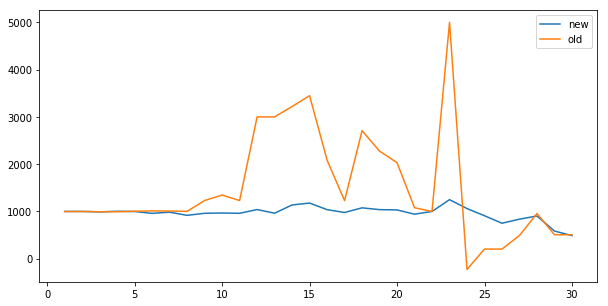

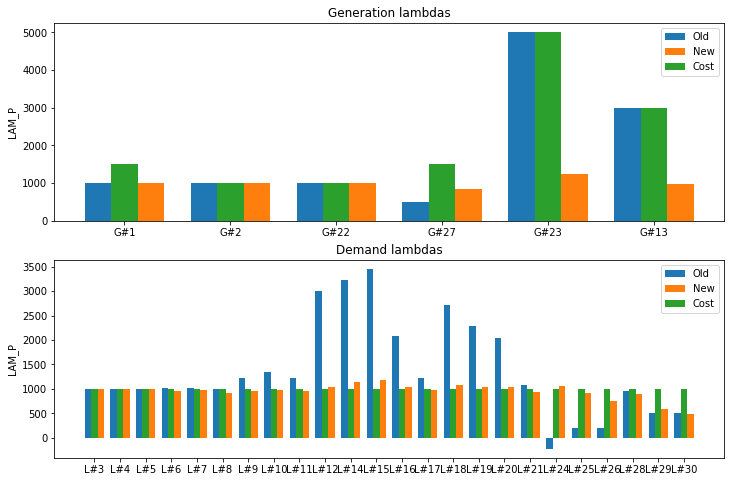

In [28]:
from drawings import draw_nice_hists, draw_nasty_profile
draw_nasty_profile(results)
draw_nice_hists(gens, results)

In [31]:
res_struct = Solver(ppc, ppopt, results,
                    threshold=threshold,
                    verbose=False)

#Var = 68
#Eq = 60
Underdetermined:  True
OrderedDict([('lam_p', 26), ('lam_q', 30), ('sigma', 8), ('mu', 4)])
f(x^*) = 274.421784


In [32]:
#all_sets = create_all_pos_settings()

In [33]:
'''
from tqdm import tqdm_notebook
for num, i in enumerate(tqdm_notebook(all_sets)):
    try:
        alg = check_opt_alg(i[0], i[1])
        res_struct = Solve(dgT, dgeqT, results, threshold, 
                           replace_func=Rand_replace, 
                           opt=i[0], 
                           alg=alg, 
                           verbose=False, 
                           idx_mode=all_forming,
                           alpha=0.2, beta=0.8)
        draw_nasty_profile(results)
        draw_nice_hists(gens, results)
        plt.show()
        if num % 10 == 1:
            clear_output()
    except:
        print(i)
        raise KeyboardInterrupt
'''

'\nfrom tqdm import tqdm_notebook\nfor num, i in enumerate(tqdm_notebook(all_sets)):\n    try:\n        alg = check_opt_alg(i[0], i[1])\n        res_struct = Solve(dgT, dgeqT, results, threshold, \n                           replace_func=Rand_replace, \n                           opt=i[0], \n                           alg=alg, \n                           verbose=False, \n                           idx_mode=all_forming,\n                           alpha=0.2, beta=0.8)\n        draw_nasty_profile(results)\n        draw_nice_hists(gens, results)\n        plt.show()\n        if num % 10 == 1:\n            clear_output()\n    except:\n        print(i)\n        raise KeyboardInterrupt\n'

# 